# Vision brain alignment : inferring IT neural activity

⚠️ For reproducing final results, please run **Requirements**, **Imports** and **Utils**, then directly jump to the last cell **Best model** at the end of this notebook.

Else, the notebook contains all work done to provide a pipeline for predicting neural activity of 168 IT neurons from images stimuli. The dataset is derived from this [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf).

Notebook by Arthur Chansel, Yann Ennassih, Bryan Gotti


## ⚠️ Requirements

In [1]:
!pip install h5py
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install torch
!pip install torchinfo
!pip install torchvision
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.7 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/gotti/.virtualenvs/brain_submission/bin/python -m pip install --upgrade pip' command.
  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached fonttools-4.57.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
You should consider upgrading via the '/home/gotti/.virtualenvs/brain_submission/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/gotti/.virtualenvs/brain_submission/bin/python -m pip install --upgrade pip' command.
  Usin

## ⚠️ Imports

In [2]:
import h5py
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from skorch import NeuralNetRegressor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation done on {device}")

Computation done on cuda


## ⚠️ Utils

In [3]:
### ================== LOAD DATA ================== ###

def load_it_data(path_to_data):
    """ 
    Load IT data from file.

    Parameters
    ----------
    path_to_data : str
        Path to the data.

    Returns
    -------
    data : np.array (x6) 
        Stimulus train/val/test; objects list train/val/test; spikes train/val.
    """

    datafile = h5py.File(os.path.join(path_to_data,'IT_data.h5'), 'r')

    stimulus_train = datafile['stimulus_train'][()]
    spikes_train = datafile['spikes_train'][()]
    objects_train = datafile['object_train'][()]
    
    stimulus_val = datafile['stimulus_val'][()]
    spikes_val = datafile['spikes_val'][()]
    objects_val = datafile['object_val'][()]
    
    stimulus_test = datafile['stimulus_test'][()]
    objects_test = datafile['object_test'][()]

    ### Decode back object type to latin
    objects_train = [obj_tmp.decode("latin-1") for obj_tmp in objects_train]
    objects_val = [obj_tmp.decode("latin-1") for obj_tmp in objects_val]
    objects_test = [obj_tmp.decode("latin-1") for obj_tmp in objects_test]

    return stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val


### ================== TRAIN / EVALUATE / HOOK ================== ###

def correlation_score(y_true, y_pred):
    """ 
    Wrapper for computing the correlation score between true and predicted values.

    Parameters
    ----------
    y_true : np.array
        True values.
    y_true : np.array
        Predicted values of same shape than y_true.

    Returns
    -------
    coeff : float 
        Correlation coefficient.
    """

    return np.array([np.corrcoef(y_true[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])])

def evaluate(predictions, spikes, keys, bins=30, ev_range=(-2.5,1)):
    """ 
    Wrapper for evaluating and plotting predicted spikes against given target spikes.

    Parameters
    ----------
    predictions : dict
        Mapping model to its predicted spikes, of same shapes than the target spikes.
    spikes : np.array
        Target spikes array.
    keys : dict
        Predictions to evaluate/plot, along with their background predictions.
    bins : int
        Number of bins to plot within each histogram.
    ev_range : tuple
        Explained variance range in histograms.
    """

    n_predictions = len(keys)
    evaluated_predictions = {k: v for k,v in predictions.items() if k in keys}

    _, axs = plt.subplots(n_predictions, 2, figsize=(10, 3*n_predictions), squeeze=False)

    for i, (key, pred) in enumerate(evaluated_predictions.items()):
        
        for background_key in keys[key]:
            background_pred = predictions[background_key]

            ev = explained_variance_score(spikes, background_pred, multioutput='raw_values')
            corr = correlation_score(spikes, background_pred)
    
            axs[i, 0].hist(ev, bins=bins, range=ev_range, alpha=0.3)
            axs[i, 1].hist(corr, bins=bins, range=(-0.5,1), alpha=0.3, label=background_key)

        ev = explained_variance_score(spikes, pred, multioutput='raw_values')
        corr = correlation_score(spikes, pred)
        
        print(f"--- {key} ---")
        print("Mean EV:", ev.mean())
        print("Mean Pearson correlation:", corr.mean())

        axs[i, 0].hist(ev, bins=bins, range=ev_range, edgecolor='black', alpha=0.7)
        axs[i, 0].set_title(f'{key} - Explained variance')
        axs[i, 0].set_xlabel('EV')
        axs[i, 0].set_ylabel('Neurons count')

        axs[i, 1].hist(corr, bins=bins, range=(-0.5,1), edgecolor='black', alpha=0.7, label=key)
        axs[i, 1].set_title(f'{key} - Correlation')
        axs[i, 1].set_xlabel('Correlation coefficient')
        axs[i, 1].set_ylabel('Neurons count')

        axs[i,1].legend()

    
    plt.tight_layout()
    plt.show()


def train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, metric_fn, epochs):
    """
    Train the model using the provided loss function and optimizer. Classic torch pipeline.
    
    Parameters
    ----------
    model : torch.nn.Module 
        The model to train.
    loss_fn : callable 
        The loss function to use.
    opt : torch.optim.Optimizer
        The optimizer to use.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training set.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation set.
    metric_fn : callable
        The metric function to use for evaluation.
    epochs : int
        Number of epochs to train for.
    """

    for ep in range(epochs):

        model.train()
        for it, batch in enumerate(train_loader):
            inputs, targets = batch

            predictions = model(inputs)
            loss = loss_fn(predictions, targets)

            loss.backward()
            opt.step()
            opt.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(train_loader), loss), end='')

        model.eval()
        with torch.no_grad():
            metric = metric_fn(val_targets.detach().cpu().numpy(), model(val_inputs).detach().cpu().numpy())
            print(', metric validation: {:.2f}'.format(metric))

    print(" ")

def extract_activations(model, imgs_tr, imgs_val, return_nodes, pca=True):
    """
    Extracts specific layers/nodes/activations from given model when feeding training and validation data.

    Parameters
    ----------
    model : nn.Module
        Model from which to extract internal nodes.
    imgs_tr : torch.tensor
        Training images used for extracting training activations.
    imgs_val : torch.tensor 
        Validation images used for extracting validation activations.
    return_nodes : list
        Nodes to extract from the given model.
    pca : bool
        Whether or not to return principal components from flattened activations.

    Returns
    -------
    activations_tr : list
        Extracted training nodes.
    activations_val : list
        Extracted validation nodes.
    """
    activations_tr = []
    activations_val = []

    for return_node in return_nodes:

        print(f"Extracting {return_node}...")
        # Place hook on wanted layer
        extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
        extractor.eval()

        with torch.no_grad():

            if pca:
                # Forward training set
                activation_tr = extractor(imgs_tr)[return_node]
                activation_tr = activation_tr.flatten(1)
                U, S, V = torch.pca_lowrank(activation_tr, 1000) # pca performed on gpu
                activation_tr = activation_tr @ V
                activations_tr.append(activation_tr.cpu())
                del activation_tr, U, S

                # Forward validation set
                activation_val = extractor(imgs_val)[return_node]
                activation_val = activation_val.flatten(1) @ V
                activations_val.append(activation_val.cpu())
                del activation_val, V

            else: # just extract whole layer
                activation_tr = extractor(imgs_tr)[return_node]
                activations_tr.append(activation_tr.cpu())

                activation_val = extractor(imgs_val)[return_node]
                activations_val.append(activation_val.cpu())
                del activation_tr, activation_val

        torch.cuda.empty_cache()
        del extractor

    del model
    print(" ")
    
    return activations_tr, activations_val


### ================== DATASETS ================== ###
    
class SpikesDataset(Dataset):

    def __init__(self, stimuli, spikes, device):
        """
        Spike activity for given stimuli.

        Parameters
        ----------
        stimuli : np.array
            Stimuli shown linked with given spikes.
        spikes : np.array
            Corresponding spikes array.
        device : str 
            Computation device.
        """
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32, device=device)
        self.spikes = torch.tensor(spikes, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        spike = self.spikes[idx]
        return stimulus, spike
    
class ActivationsDataset(Dataset):
    def __init__(self, activations, spikes, device):
        """
        Spike activity for given neural activations.

        Parameters
        ----------
        activations : np.array
            Neural activations array linked with given spikes.
        spikes : np.array
            Corresponding spikes array.
        device : str 
            Computation device.
        """
        self.activations = torch.tensor(activations, dtype=torch.float32, device=device)
        self.spikes = torch.tensor(spikes, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.activations)

    def __getitem__(self, idx):
        activation = self.activations[idx]
        spike = self.spikes[idx]
        return activation, spike


### ================== MODELS ================== ###

class SpikesCNN(nn.Module):
    
    def __init__(self, input_size=224, input_channels=3, num_filters=(8, 16), num_hidden=4096, output_size=168):
        """
        Convolutional neural network for deriving spikes from images.

        Parameters
        ----------
        input_size : int
            Size of one side of the input images (assumed square). Note that given the two
            pooling layers, the input size should be divisible by 4.
        input_channels : int
            Number of channels in the input images (e.g., 3 for RGB).
        num_filters : tuple 
            Number of filters for each convolutional layer.
        num_hidden : int
            Number of hidden units in the fully connected layer.
        output_size : int
            Number of output units of the CNN.
        """
        super(SpikesCNN, self).__init__()
        assert input_size % 4 == 0, "Input size must be divisible by 4 due to pooling layers."
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=5, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=5, padding="same")
        self.fc1 = nn.Linear(num_filters[1] * int(input_size / 4)**2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SmallSpikesCNN(nn.Module):
    def __init__(self, input_size=224, input_channels=3, num_filters=(4, 8, 8), num_hidden=2048, output_size=168):
        """
        Small convolutional neural network for deriving spikes from images.

        Parameters
        ----------
        input_size : int
            Size of one side of the input images (assumed square). Note that given the two
            pooling layers, the input size should be divisible by 4.
        input_channels : int
            Number of channels in the input images (e.g., 3 for RGB).
        num_filters : tuple 
            Number of filters for each convolutional layer.
        num_hidden : int
            Number of hidden units in the fully connected layer.
        output_size : int
            Number of output units of the CNN.
        """
        super(SmallSpikesCNN, self).__init__()
        assert input_size % 8 == 0, "Input size must be divisible by 4 due to pooling layers."
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_filters[2] * int(input_size / 8)**2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ActivationsFFN(nn.Module):
    def __init__(self, input_size=1000, hidden_1_size=2**10, hidden_2_size=2**9, output_size=168, dropout=0):
        """
        Feed forward network for fitting spiking activity from flattened activations. 

        Parameters
        ----------
        input_size : int
            Flattened input size.
        hidden_1_size : int
            Number of hidden units in the 1st fully connected layer.
        hidden_2_size : int 
            Number of hidden units in the 2nd fully connected layer.
        output_size : int
            Number of output units of the FFN.
        dropout : float
            Ratio of neurons to ignore.
        """
        super(ActivationsFFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.fc3 = nn.Linear(hidden_2_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
class ActivationsCNN(nn.Module):
    def __init__(self, input_size=7, input_channels=2048, num_filters=(2048, 1024), num_hidden=1024, output_size=168, dropout=0):
        """
        Convolutional neural network for fitting spiking activity from resnet convolutions. 

        Parameters
        ----------
        input_size : int
            Convolution input channel size.
        input_channels : int
            Number of input channels.
        num_filters : tuple 
            Number of filters for each convolutional layer.
        num_hidden : int
            Number of hidden units in the fully connected layer.
        output_size : int
            Number of output units of the CNN.
        dropout : float
            Ratio of neurons to ignore.
        """
        super(ActivationsCNN, self).__init__()
    
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding="same")
        linear_input_size = int(np.ceil(np.ceil(input_size / 2) / 2) ** 2) * num_filters[1]
        self.fc1 = nn.Linear(linear_input_size, num_hidden)
        self.fc2 = nn.Linear(num_hidden, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### ================== FINAL MODEL ================== ###

def predict_with_best_model(stimulus_train, spikes_train, stimulus_test):
    """ 
    Wrapper for loading the best pipeline.
    
    Parameters
    ----------
    stimulus_train : np.array
        Training stimulus.
    spikes_train : np.array
        Training target spikes.
    stimulus_test : np.array 
        Testing stimulus.

    Returns
    -------
    prediction: np.array
        Predicted spikes.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Computation on {device}.")
    
    print("--- Pretrained Resnet50-barlow --- ")
    model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    model = model.to(device)
    model.eval()

    imgs_tr = torch.from_numpy(stimulus_train).to(device)
    imgs_test = torch.from_numpy(stimulus_test).to(device)

    return_nodes = ['layer4.0']

    # Run the pre-trained model to get the activations
    activations_tr, activations_val = extract_activations(model, imgs_tr, imgs_test, return_nodes)
    activation_tr, activation_test = activations_tr[0], activations_val[0]

    reg = Ridge(22570.20)
    reg.fit(activation_tr, spikes_train)

    return reg.predict(activation_test)

### Data loading ###

In [4]:
path_to_data = '.'

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
x_train = stimulus_train.reshape((stimulus_train.shape[0], -1)) # flattened images used for linear regression
x_val = stimulus_val.reshape((stimulus_val.shape[0], -1))

n_stimulus = stimulus_train.shape[0]
n_neurons = spikes_train.shape[1]

print(f"Image stimuli of shapes: train {stimulus_train.shape} validation {stimulus_val.shape}")
print(f"Flattened stimuli of shapes: train {x_train.shape} validation {x_val.shape}")
print(f"Neural activity of shapes: train {spikes_train.shape} validation {spikes_val.shape}")

Image stimuli of shapes: train (2592, 3, 224, 224) validation (288, 3, 224, 224)
Flattened stimuli of shapes: train (2592, 150528) validation (288, 150528)
Neural activity of shapes: train (2592, 168) validation (288, 168)


## Linear regression

/home/gotti/.virtualenvs/brain_submission/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=4.7811e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


--- least_squares ---
Mean EV: -0.033401508
Mean Pearson correlation: 0.21750064455222043
--- ridge ---
Mean EV: -1.1573758
Mean Pearson correlation: 0.14668690500674206


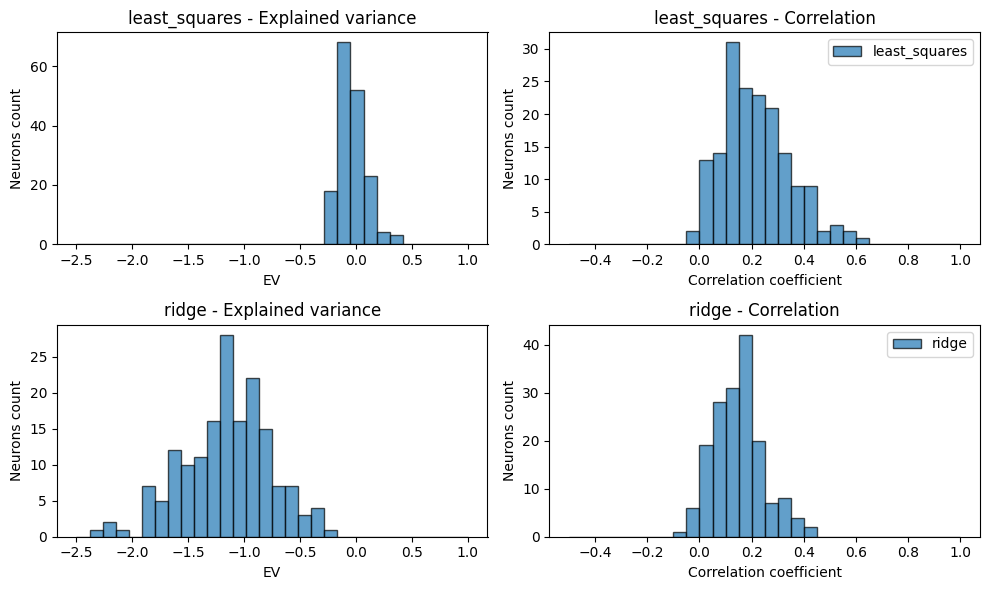

In [5]:
predictions = {}

# Ordinary Least-Squares
least_squares = LinearRegression()
least_squares.fit(x_train, spikes_train)
predictions['least_squares'] = least_squares.predict(x_val)

# Ridge Regression
ridge = Ridge()
ridge.fit(x_train, spikes_train)
predictions['ridge'] = ridge.predict(x_val)

# Evaluate and plot
keys = {'least_squares': [], 'ridge': []} # empty values means no background plot
evaluate(predictions, spikes_val, keys)

From this first naive approach, OLS and Ridge have similar poor fit.

--- least_squares_pca ---
Mean EV: -0.08472631
Mean Pearson correlation: 0.2177131535962758
--- ridge_pca ---
Mean EV: -0.084706284
Mean Pearson correlation: 0.2177170790666519


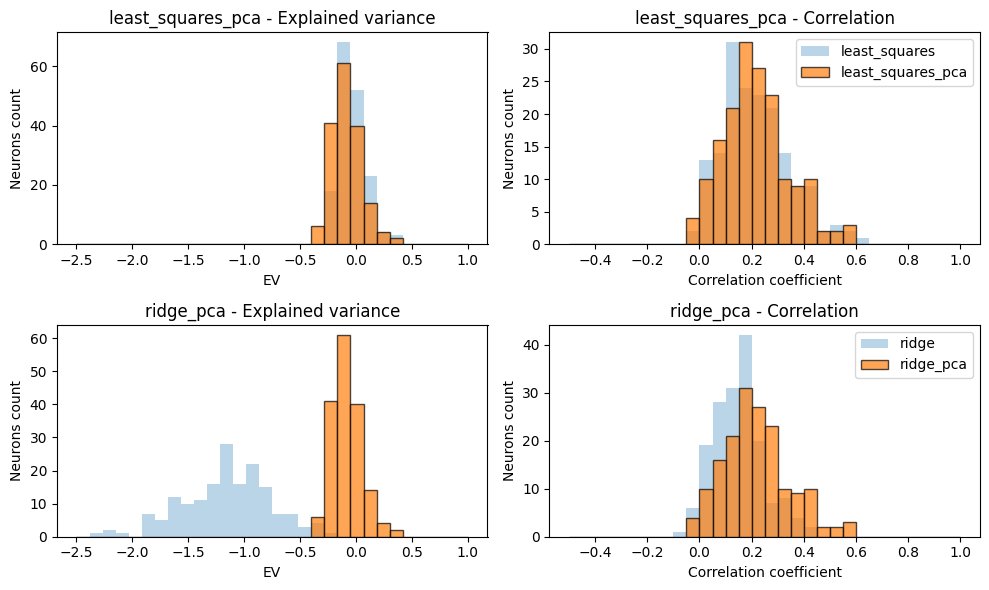

In [6]:
# Using principal components
pca = PCA(n_components=1000)
x_train_pcs = pca.fit_transform(x_train)
x_val_pcs = pca.transform(x_val)

least_squares = LinearRegression()
least_squares.fit(x_train_pcs, spikes_train)
predictions['least_squares_pca'] = least_squares.predict(x_val_pcs)
                                                
ridge = Ridge()
ridge.fit(x_train_pcs, spikes_train)
predictions['ridge_pca'] = ridge.predict(x_val_pcs)

keys = {'least_squares_pca': ['least_squares'], 'ridge_pca': ['ridge']}
evaluate(predictions, spikes_val, keys)

Linear dimensionality reduction considerably improves both fits.

Best alpha: 343046.93
--- grid_ridge_pca ---
Mean EV: 0.09255253
Mean Pearson correlation: 0.2850709779770698


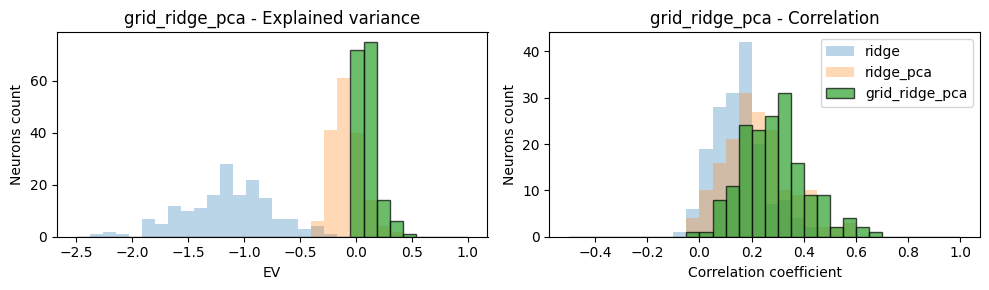

In [7]:
# Cross validation to find best Ridge regularization parameter
param_grid = {'alpha': np.logspace(-3, 10, 100)}
cv = StratifiedKFold(shuffle=True)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(np.zeros(n_stimulus), objects_train), scoring='explained_variance', n_jobs=-1)
cv_ridge.fit(x_train_pcs, spikes_train)
best_ridge = cv_ridge.best_estimator_
best_alpha = cv_ridge.best_params_['alpha']
print(f"Best alpha: {best_alpha:.2f}")

predictions["grid_ridge_pca"] = best_ridge.predict(x_val_pcs)

keys = {'grid_ridge_pca': ['ridge', 'ridge_pca']}
evaluate(predictions, spikes_val, keys)

Fine tuning the regularization scale parameter of the Ridge estimator slightly improves the fit.

## Task-driven approach

Do complex layer activations trained on object recognition predict IT spiking activities ?

In [8]:
imgs_tr = torch.from_numpy(stimulus_train).to(device)
imgs_val = torch.from_numpy(stimulus_val).to(device)

return_nodes = ['conv1','layer1','layer2','layer3','layer4','avgpool']

print("--- Pretrained Resnet50 --- ")
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

activations_tr, activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)

print("--- Random initialized Resnet50 ---")
model = resnet50() 
model = model.to(device)
model.eval()

rand_activations_tr, rand_activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)

--- Pretrained Resnet50 --- 
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/gotti/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 271MB/s]


Extracting conv1...
Extracting layer1...
Extracting layer2...
Extracting layer3...
Extracting layer4...
Extracting avgpool...
 
--- Random initialized Resnet50 ---
Extracting conv1...
Extracting layer1...
Extracting layer2...
Extracting layer3...
Extracting layer4...
Extracting avgpool...
 


--- resnet_conv1 ---
Mean EV: -0.027693468858869134
Mean Pearson correlation: 0.23867002979003035
--- resnet_layer1 ---
Mean EV: 0.2533003364472502
Mean Pearson correlation: 0.49097370936474605
--- resnet_layer2 ---
Mean EV: 0.3298860735202171
Mean Pearson correlation: 0.5632907638875156
--- resnet_layer3 ---
Mean EV: 0.4074499998026675
Mean Pearson correlation: 0.6294521274978231
--- resnet_layer4 ---
Mean EV: 0.35397265110321674
Mean Pearson correlation: 0.5915753244124722
--- resnet_avgpool ---
Mean EV: 0.12187643947733239
Mean Pearson correlation: 0.4701408915474178


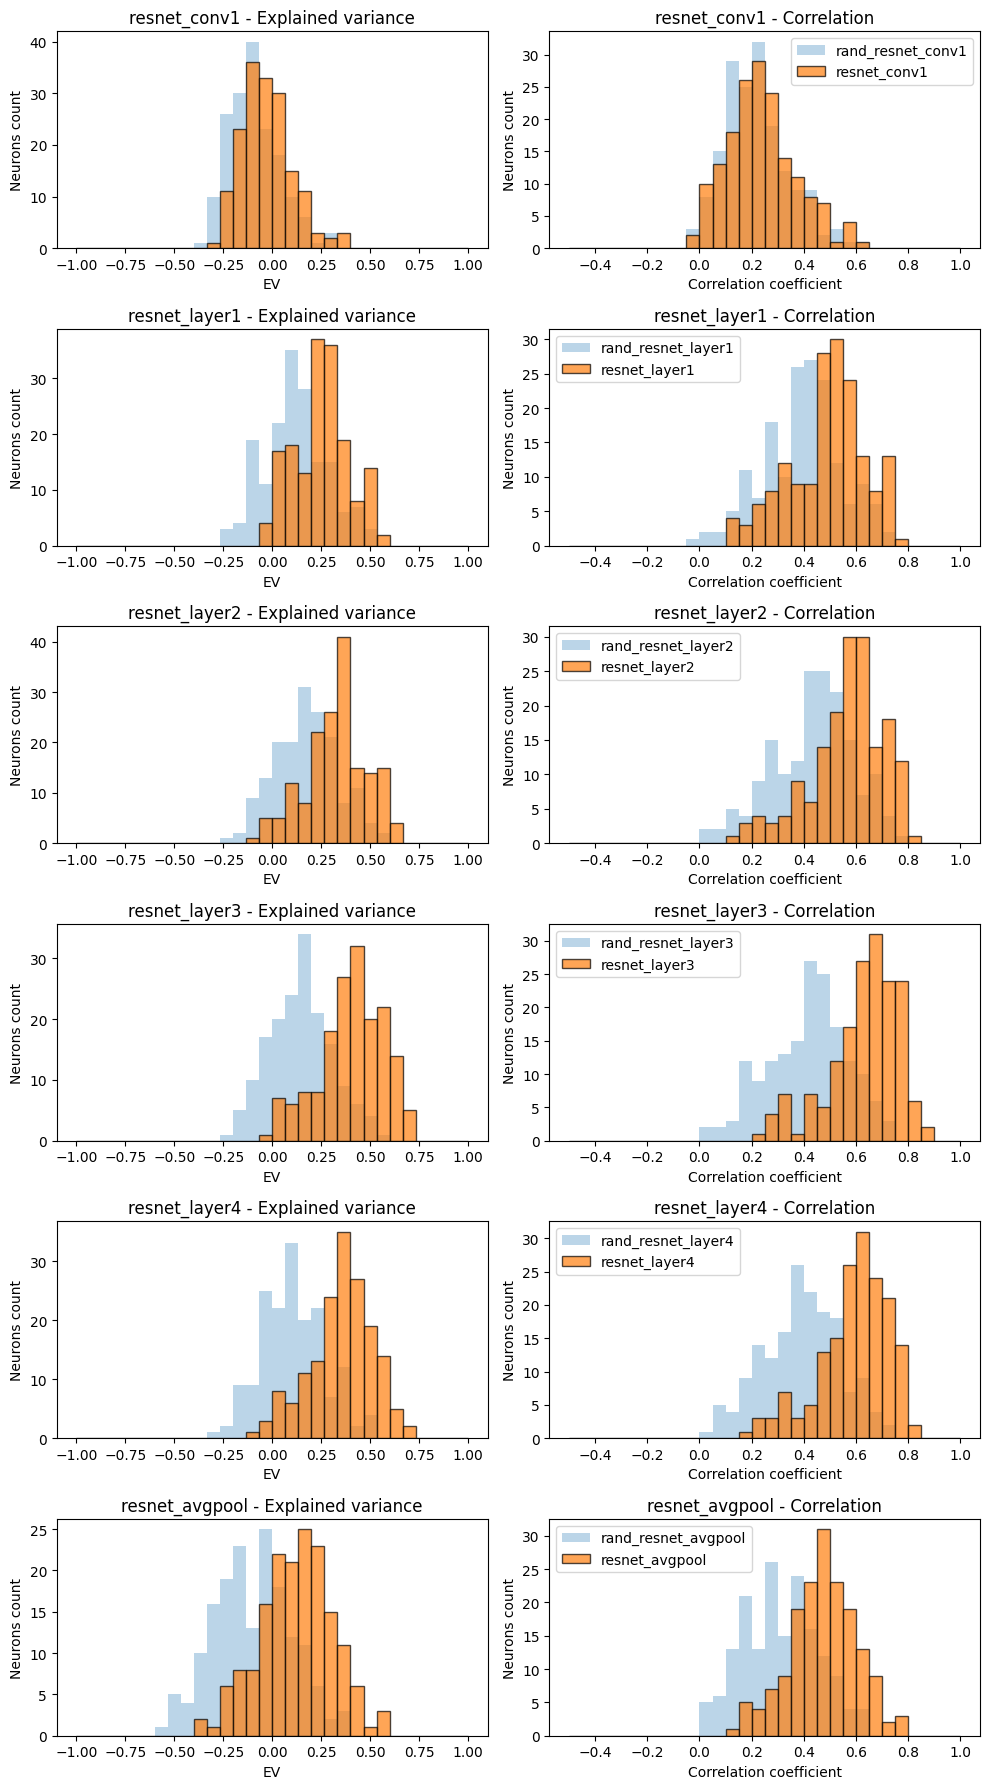

In [9]:
for i in range(len(return_nodes)):
    return_node = "resnet_" + return_nodes[i]

    reg = Ridge()
    reg.fit(activations_tr[i], spikes_train)
    y_pred = reg.predict(activations_val[i])
    predictions[return_node] = reg.predict(activations_val[i])

    rand_reg = Ridge()
    rand_reg.fit(rand_activations_tr[i], spikes_train)
    predictions["rand_" + return_node] = rand_reg.predict(rand_activations_val[i])

keys = {
    'resnet_conv1': ['rand_resnet_conv1'],
    'resnet_layer1': ['rand_resnet_layer1'],
    'resnet_layer2': ['rand_resnet_layer2'],
    'resnet_layer3': ['rand_resnet_layer3'], 
    'resnet_layer4': ['rand_resnet_layer4'],
    'resnet_avgpool': ['rand_resnet_avgpool']
    }
evaluate(predictions, spikes_val, keys, ev_range=(-1,1))

As expected, pretrained internal representations better explaines the neural spiking than random initialized ones.

## Data-driven approach

How well does training CNNs to directly fit the spiking activity from the images work ?

In [10]:
train_dataset = SpikesDataset(stimulus_train, spikes_train, device)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_inputs = torch.tensor(stimulus_val, dtype=torch.float32, device=device)
val_targets = torch.tensor(spikes_val, dtype=torch.float32, device=device)

# Display 1st batch shape
for stimuli_batch, spikes_batch in train_loader:
    print(f"Stimuli batch shape: {stimuli_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

Stimuli batch shape: torch.Size([8, 3, 224, 224])
Spikes batch shape: torch.Size([8, 168])


In [11]:
model = SpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

Ep 1/10, it 324/324: loss train: 0.12, metric validation: 0.09
Ep 2/10, it 324/324: loss train: 0.10, metric validation: 0.18
Ep 3/10, it 324/324: loss train: 0.09, metric validation: 0.21
Ep 4/10, it 324/324: loss train: 0.05, metric validation: 0.21
Ep 5/10, it 324/324: loss train: 0.04, metric validation: 0.20
Ep 6/10, it 324/324: loss train: 0.04, metric validation: 0.19
Ep 7/10, it 324/324: loss train: 0.03, metric validation: 0.18
Ep 8/10, it 324/324: loss train: 0.03, metric validation: 0.18
Ep 9/10, it 324/324: loss train: 0.02, metric validation: 0.18
Ep 10/10, it 324/324: loss train: 0.02, metric validation: 0.16
 


After 3 epochs, it has already overfitted the training set. Let's try to make the model smaller:

In [14]:
print("--- SmallSpikesCNN ---")
small_model = SmallSpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(small_model.parameters(), lr=0.001)

train_model(small_model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

print("--- VerySmallSpikesCNN ---")
very_small_model = SmallSpikesCNN(num_filters=(2, 4, 4), num_hidden=256).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(very_small_model.parameters(), lr=0.001)

train_model(small_model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=10)

--- SmallSpikesCNN ---
Ep 1/10, it 324/324: loss train: 0.10, metric validation: 0.20
Ep 2/10, it 324/324: loss train: 0.09, metric validation: 0.23
Ep 3/10, it 324/324: loss train: 0.09, metric validation: 0.23
Ep 4/10, it 324/324: loss train: 0.07, metric validation: 0.22
Ep 5/10, it 324/324: loss train: 0.05, metric validation: 0.23
Ep 6/10, it 324/324: loss train: 0.04, metric validation: 0.21
Ep 7/10, it 324/324: loss train: 0.03, metric validation: 0.21
Ep 8/10, it 324/324: loss train: 0.03, metric validation: 0.21
Ep 9/10, it 324/324: loss train: 0.03, metric validation: 0.19
Ep 10/10, it 324/324: loss train: 0.03, metric validation: 0.19
 
--- VerySmallSpikesCNN ---
Ep 1/10, it 324/324: loss train: 0.02, metric validation: 0.19
Ep 2/10, it 324/324: loss train: 0.02, metric validation: 0.19
Ep 3/10, it 324/324: loss train: 0.02, metric validation: 0.19
Ep 4/10, it 324/324: loss train: 0.03, metric validation: 0.19
Ep 5/10, it 324/324: loss train: 0.02, metric validation: 0.19
Ep

We see that a model that is too small is no longer able to learn the task well enough. We will thus keep the `small_model` as our final data-driven model, trained for 5 epochs.

Ep 1/5, it 324/324: loss train: 0.12, metric validation: 0.12
Ep 2/5, it 324/324: loss train: 0.10, metric validation: 0.20
Ep 3/5, it 324/324: loss train: 0.11, metric validation: 0.22
Ep 4/5, it 324/324: loss train: 0.09, metric validation: 0.23
Ep 5/5, it 324/324: loss train: 0.09, metric validation: 0.22
 
--- small_spikes_cnn ---
Mean EV: 0.22452056
Mean Pearson correlation: 0.4597098100219942


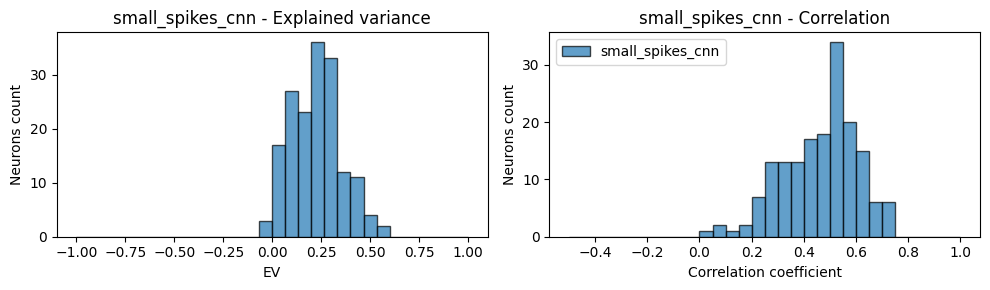

In [16]:
model = SmallSpikesCNN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=5)

model.eval()
predictions["small_spikes_cnn"] = model(val_inputs).detach().cpu().numpy()
keys = {"small_spikes_cnn": []}
evaluate(predictions, spikes_val, keys, ev_range=(-1, 1))

Results show comparable or slightly worse performance than layers of the pretrained resnet50. 

## Further investigation

The following complementary study is based on the pretrained "Barlow Twins: Self-Supervised Learning via Redundancy Reduction" resnet50-based model.
This model achieves rank 1 Brain-Score on the MajajHong2015-IT dataset and IT neurons best align with 'layer4.0'.

SRC : https://www.brain-score.org/model/vision/1310 & https://github.com/facebookresearch/barlowtwins


### Barlow -> Flatten -> PCA -> GridSearch Ridge

In [17]:
return_nodes = ['layer4.0']

print("--- Pretrained Resnet50-barlow --- ")
model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = model.to(device)
model.eval()

activations_tr, activations_val = extract_activations(model, imgs_tr, imgs_val, return_nodes)
activation_tr, activation_val = activations_tr[0], activations_val[0]

--- Pretrained Resnet50-barlow --- 


Using cache found in /home/gotti/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/gotti/.virtualenvs/brain_submission/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotti/.virtualenvs/brain_submission/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Extracting layer4.0...
 


Best alpha: 22570.20
--- grid_ridge_pca_barlow ---
Mean EV: 0.4552622560644395
Mean Pearson correlation: 0.6674093695664747


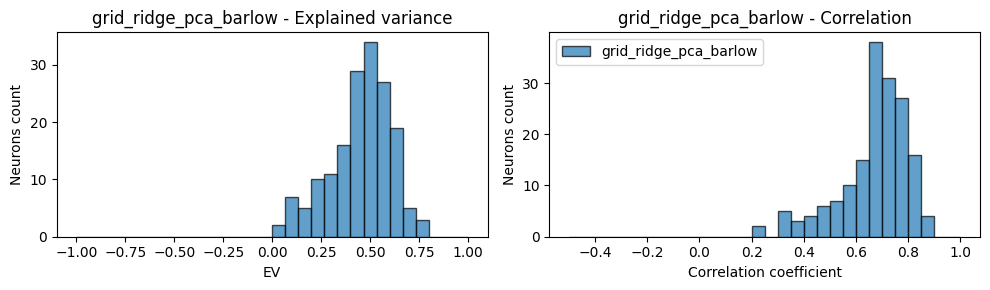

In [18]:
# Cross validation to find best Ridge regularization parameter
param_grid = {'alpha': np.logspace(-3, 10, 100)}
cv = StratifiedKFold(shuffle=True)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(np.zeros(n_stimulus), objects_train), scoring='explained_variance', n_jobs=-1)
cv_ridge.fit(activation_tr, spikes_train)
best_ridge = cv_ridge.best_estimator_
best_alpha = cv_ridge.best_params_['alpha']
print(f"Best alpha: {best_alpha:.2f}")

predictions["grid_ridge_pca_barlow"] = best_ridge.predict(activation_val)

keys = {'grid_ridge_pca_barlow': []}
evaluate(predictions, spikes_val, keys, ev_range=(-1,1))

The Barlow layer4.0 outperforms all previous work. But maybe adding a fully connected network (hence a non-linear function) on top of it improves the performance ?



### Barlow -> FFN

Running a Feed Forward Network (FFN) directly on the flattened activations from layer4.0, without PCA, yields terrible results: the optimizer seems to handle the input data really badly, and after a few epochs the model's parameters are such that the model outputs always the exact same thing, no matter its input. This may be due to the high sparsity of the activations (around 80% of the activations are 0), which probably messes up the optimizer. By using PCA, we reduce the sparsity of the activations, and the optimizer seems to work much better.

### Barlow -> Flatten -> PCA -> FFN

/tmp/ipykernel_978421/4192299957.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.activations = torch.tensor(activations, dtype=torch.float32, device=device)
/tmp/ipykernel_978421/1035954839.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(activation_val, dtype=torch.float32, device=device)


Stimuli batch shape: torch.Size([8, 1000])
Spikes batch shape: torch.Size([8, 168])
Ep 1/20, it 324/324: loss train: 0.10, metric validation: 0.28
Ep 2/20, it 324/324: loss train: 0.09, metric validation: 0.33
Ep 3/20, it 324/324: loss train: 0.07, metric validation: 0.35
Ep 4/20, it 324/324: loss train: 0.08, metric validation: 0.37
Ep 5/20, it 324/324: loss train: 0.06, metric validation: 0.37
Ep 6/20, it 324/324: loss train: 0.05, metric validation: 0.37
Ep 7/20, it 324/324: loss train: 0.06, metric validation: 0.38
Ep 8/20, it 324/324: loss train: 0.06, metric validation: 0.38
Ep 9/20, it 324/324: loss train: 0.06, metric validation: 0.38
Ep 10/20, it 324/324: loss train: 0.05, metric validation: 0.38
Ep 11/20, it 324/324: loss train: 0.05, metric validation: 0.38
Ep 12/20, it 324/324: loss train: 0.06, metric validation: 0.38
Ep 13/20, it 324/324: loss train: 0.05, metric validation: 0.38
Ep 14/20, it 324/324: loss train: 0.06, metric validation: 0.37
Ep 15/20, it 324/324: loss tr

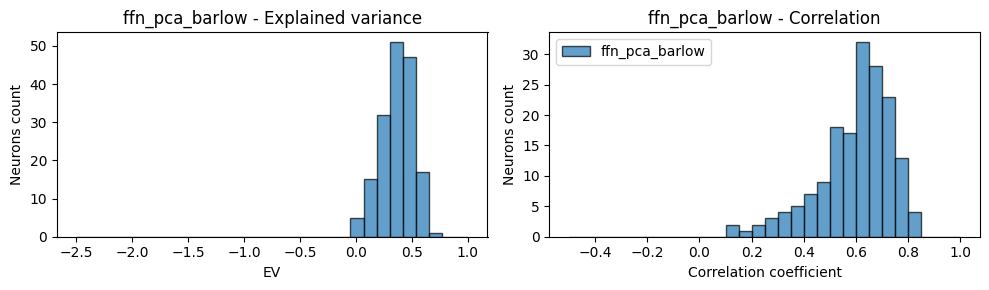

In [19]:
train_dataset = ActivationsDataset(activation_tr, spikes_train, device)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_inputs = torch.tensor(activation_val, dtype=torch.float32, device=device)
val_targets = torch.tensor(spikes_val, dtype=torch.float32, device=device)

for stimuli_batch, spikes_batch in train_loader:
    print(f"Stimuli batch shape: {stimuli_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

activations_ffn = ActivationsFFN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(activations_ffn.parameters(), lr=0.001)
train_model(activations_ffn, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=20)

activations_ffn.eval()
predictions["ffn_pca_barlow"] = activations_ffn(val_inputs).detach().cpu().numpy()
keys = {"ffn_pca_barlow": []}
evaluate(predictions, spikes_val, keys)

The non-linear output regression underperforms compared to Ridge. The FFN needs hyperparameters tuning.

### Barlow -> Flatten -> PCA -> GridSearch FFN

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Best parameters found: (np.float64(0.35436607400576275), {'lr': 0.001, 'module__dropout': 0, 'optimizer__weight_decay': 0.001})
--- grid_ffn_pca_barlow ---
Mean EV: 0.41236988
Mean Pearson correlation: 0.6324599032765119


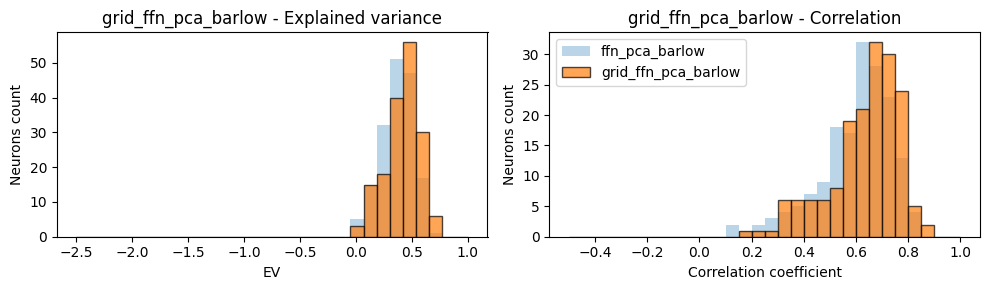

In [20]:
# Run a grid search to find the best hyperparameters
net = NeuralNetRegressor(
    ActivationsFFN,
    max_epochs=20,
    lr=0.001,
    verbose=0,
    train_split=False,
    optimizer=torch.optim.Adam,
    device=device
)

params = {
    'optimizer__weight_decay': [0.0, 0.001, 0.01, 0.1],
    'module__dropout': [0, 0.2, 0.35, 0.5],
    'lr': [0.001, 0.01, 0.1],
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring='explained_variance', verbose=1)
gs.fit(activation_tr.cpu().numpy(), spikes_train)
print(f"Best parameters found: {gs.best_score_, gs.best_params_}")

predictions['grid_ffn_pca_barlow'] = gs.best_estimator_.predict(activation_val.cpu().numpy())
keys = {"grid_ffn_pca_barlow": ['ffn_pca_barlow']}
evaluate(predictions, spikes_val, keys)

Hyperparameter tuning of the FFN enables closer fit to what has been done before. However, it does not improve previous work. Instead of a FFN, let's to add a CNN on top of layer4.0.

### Barlow -> GridSearch CNN

Extracting layer4.0...
 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: (np.float64(0.32311633229255676), {'lr': 0.001, 'module__dropout': 0, 'optimizer__weight_decay': 0.001})
--- grid_cnn_barlow ---
Mean EV: 0.37462395
Mean Pearson correlation: 0.5998012946084966


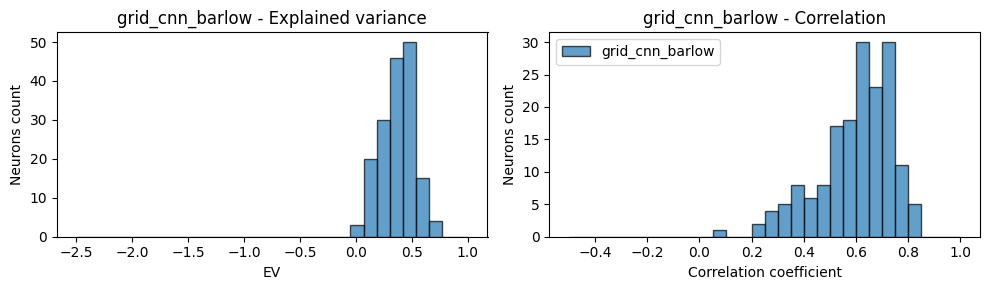

In [21]:
convolutions_tr, convolutions_val = extract_activations(model, imgs_tr, imgs_val, return_nodes, pca=False)
convolution_tr = convolutions_tr[0].to(device)
convolution_val = convolutions_val[0].to(device)

net = NeuralNetRegressor(
    ActivationsCNN,
    max_epochs=20,
    lr=0.001,
    verbose=0,
    train_split=False,
    optimizer=torch.optim.Adam,
    device=device
)

# May take few minutes
params = {
    'optimizer__weight_decay': [0.001, 0.01],
    'module__dropout': [0, 0.25, 0.5],
    'lr': [0.001, 0.01],
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring='explained_variance', verbose=1)
gs.fit(convolution_tr.cpu().numpy(), spikes_train)
print(f"Best parameters found: {gs.best_score_, gs.best_params_}")

predictions['grid_cnn_barlow'] = gs.best_estimator_.predict(convolution_val.cpu().numpy())
keys = {"grid_cnn_barlow": []}
evaluate(predictions, spikes_val, keys)

The CNN does not achieve better performance than a FFN, even with parameter tuning.

## Models comparison

In [22]:
print(f"{'Model'.ljust(22)}  {'Mean EV'.rjust(8)} {'Mean CORR'.rjust(8)}")

for model, prediction in predictions.items():

    mean_ev = explained_variance_score(spikes_val, prediction, multioutput='raw_values').mean()
    mean_corr = correlation_score(spikes_val, prediction).mean()
    print(f"{model.ljust(20)}  {f'{mean_ev:.4f}'.rjust(8)} {f'{mean_corr:.4f}'.rjust(8)}")

Model                    Mean EV Mean CORR
least_squares          -0.0334   0.2175
ridge                  -1.1574   0.1467
least_squares_pca      -0.0847   0.2177
ridge_pca              -0.0847   0.2177
grid_ridge_pca          0.0926   0.2851
resnet_conv1           -0.0277   0.2387
rand_resnet_conv1      -0.0926   0.2175
resnet_layer1           0.2533   0.4910
rand_resnet_layer1      0.1172   0.3945
resnet_layer2           0.3299   0.5633
rand_resnet_layer2      0.1724   0.4334
resnet_layer3           0.4074   0.6295
rand_resnet_layer3      0.1452   0.4145
resnet_layer4           0.3540   0.5916
rand_resnet_layer4      0.1069   0.3893
resnet_avgpool          0.1219   0.4701
rand_resnet_avgpool    -0.1021   0.3076
small_spikes_cnn        0.2245   0.4597
grid_ridge_pca_barlow    0.4553   0.6674
ffn_pca_barlow          0.3663   0.5983
grid_ffn_pca_barlow     0.4124   0.6325
grid_cnn_barlow         0.3746   0.5998


# Best model

⚠️ Make sure to load all imports and utils cells at the beginning of the notebook.

Run the cell below to reproduce our best results, based on the **grid_ridge_pca_barlow** pipeline. 


Computation on cuda.
--- Pretrained Resnet50-barlow --- 


Using cache found in /home/gotti/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/gotti/.virtualenvs/brain_submission/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotti/.virtualenvs/brain_submission/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Extracting layer4.0...
 
--- best_model ---
Mean EV: 0.4553513267448923
Mean Pearson correlation: 0.6673931286487804


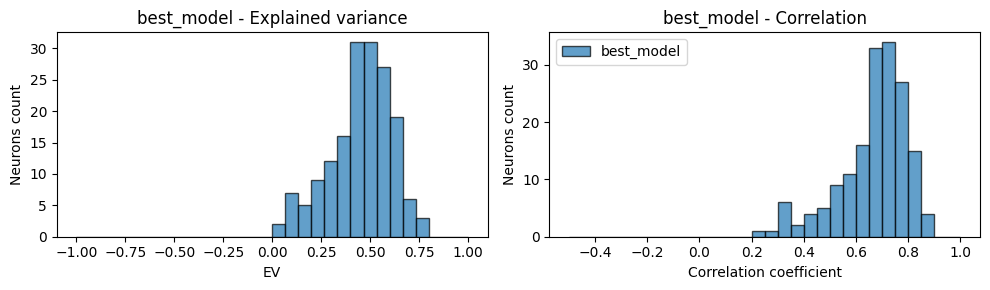

In [23]:
it_data_dir = '.'
stimulus_train, stimulus_val, _, _, _, _, spikes_train, spikes_val = load_it_data(it_data_dir)

# Replace these by the data you want to test. 
# By default we give here the validation set of IT_data.h5.
stimulus_test = stimulus_val 
target_test = spikes_val 

best_prediction = predict_with_best_model(stimulus_train, spikes_train, stimulus_test)

keys = {'best_model': []}
evaluate({'best_model': best_prediction}, target_test, keys, ev_range=(-1,1))